<a href="https://colab.research.google.com/github/ameeshafareen/PRODIGY_GA_04/blob/main/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving vangoghvase.jpg to vangoghvase.jpg
Saving cinderlla.jpg to cinderlla.jpg


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 138MB/s]


Total loss:  191371824.0
Total loss:  80573552.0
Total loss:  53434312.0
Total loss:  38943564.0
Total loss:  28957778.0
Total loss:  21903828.0
Total loss:  17095542.0
Total loss:  13817168.0
Total loss:  11503422.0
Total loss:  9788595.0
Total loss:  8447520.0
Total loss:  7359341.5
Total loss:  6452923.0
Total loss:  5683254.0
Total loss:  5018582.0
Total loss:  4439721.0
Total loss:  3933301.75
Total loss:  3488443.5
Total loss:  3096320.25
Total loss:  2750198.75


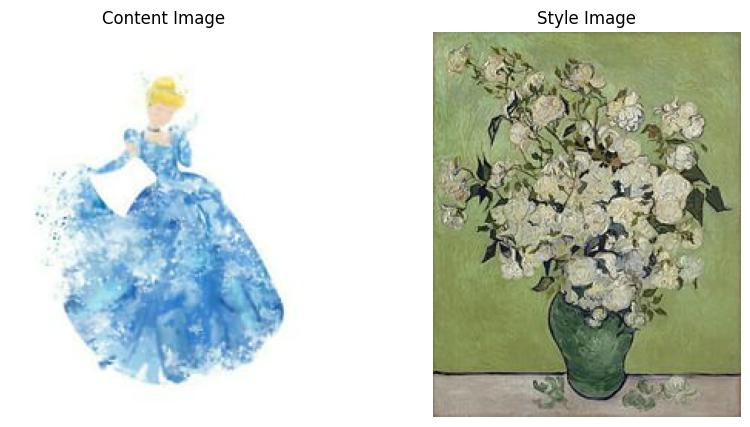

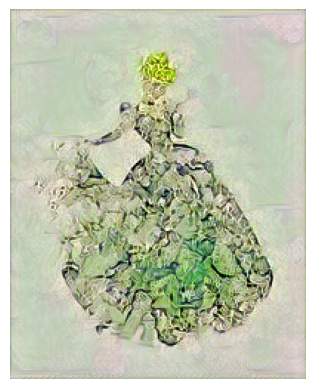

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load images
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    size = max(max(image.size), max_size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    image = in_transform(image).unsqueeze(0)
    return image
from google.colab import files

# Upload the images
uploaded = files.upload()

content_image = load_image('cinderlla.jpg')
style_image = load_image('vangoghvase.jpg')

content_image = load_image('cinderlla.jpg', shape=(250, 200)).to('cuda')
style_image = load_image('vangoghvase.jpg', shape=(250, 200)).to('cuda')

# Define model
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)
vgg.to('cuda')

# Layers for content and style features
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

# Get features
def get_features(image, model, layers=None):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Get content and style features
content_features = get_features(content_image, vgg, {'21': 'conv4_2'})
style_features = get_features(style_image, vgg, {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'})
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Initialize target image
target = content_image.clone().requires_grad_(True).to('cuda')

# Style and content weights
style_weights = {'conv1_1': 1., 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1
style_weight = 1e6

# Define optimizer
optimizer = optim.Adam([target], lr=0.003)

# Training loop
steps = 2000
for i in range(steps):
    target_features = get_features(target, vgg, {'21': 'conv4_2', '0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'})

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print('Total loss: ', total_loss.item())
content_image = Image.open('cinderlla.jpg')
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')

# Load and display the style image
style_image = Image.open('vangoghvase.jpg')
plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title('Style Image')
plt.axis('off')

plt.show()

# Display the image
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    return image

final_image = im_convert(target)

# Display the final image
plt.imshow(final_image)
plt.axis('off')
plt.show()

# Save the image
final_image_pil = Image.fromarray((final_image * 255).astype('uint8'))
final_image_pil.save('output_image.jpg')
